In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass

In [ ]:
# Given a (relative) filepath to a csv output from the scope, returns two arrays
# first array: time in seconds, second array: signal in volts
def load_scope_data(filepath):
    data = pd.read_csv(filepath, skiprows=2, header=None)

    time_seconds = np.array(data[0].values)  # First column is time
    voltage_volts = np.array(data[1].values)  # Second column is voltage

    # Adjust time to start at zero
    time_zero_based = time_seconds - time_seconds.min()
    return (time_zero_based, voltage_volts)


In [33]:
@dataclass
class ScopeData:
    filepath: str 
    starting_channel: int # Channels are labeled 0-7, 0 being the highest amplitude channel
    first_step_end_time: float # time where the first step transition happens


1.000000000001e-06


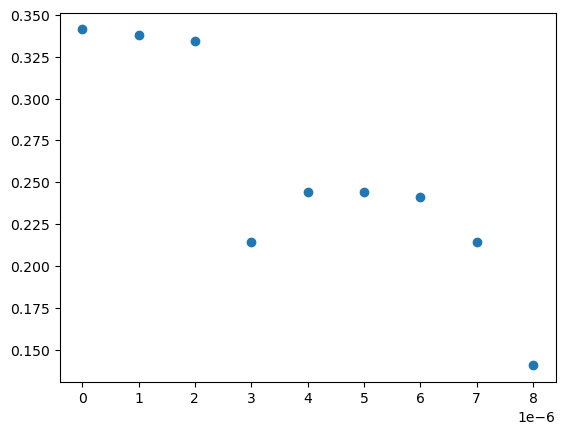

In [35]:
# I'm going to manually describe the starting conditions of the 8 csv's I have
ts, vs = load_scope_data("./scope traces/herzan64mscsv1.csv")
print(ts[1] - ts[0])
end_point = 9
plt.scatter(ts[:end_point], vs[:end_point]) #, s=np.ones_like(ts[:40]))

plt.show()